# 小市值因子检测

## 原理：
1. 通过alphalens工具，生成未来一段时间小市值因子的收益
2. 对比大盘收益与小市值因子的收益
3. 通过双均线的对比，确认入手的时机

### 步骤1：生成小市值因子收益率曲线

In [1]:
#参数及工具函数部分
import pandas as pd
import numpy as np
from jqfactor import *
import warnings  
warnings.filterwarnings('ignore')


In [2]:
# plt的默认设置
plt.rcParams['figure.figsize'] = [12.0, 8.0]  # 宽度, 高度

plt.rcParams['axes.spines.right']= False
plt.rcParams['axes.spines.top']= False
plt.rcParams['axes.spines.left']= False
plt.rcParams['axes.spines.bottom']=False

plt.rcParams['axes.labelsize'] = 14  # 设置坐标轴标签字体大小
plt.rcParams['axes.titlesize'] = 16  # 设置标题字体大小
plt.rcParams['xtick.labelsize'] = 12  # 设置x轴刻度标签字体大小
plt.rcParams['ytick.labelsize'] = 12  # 设置y轴刻度标签字体大小
plt.rcParams['grid.alpha'] = 1  # 设置网格透明度

plt.rcParams['axes.grid'] = True # 设置网格线

plt.rcParams['legend.fontsize'] = 16 

plt.rcParams['font.family'] = "monospace" # 设置图片字体

In [3]:
# 提取因子数据

#参数及工具函数部分
import pandas as pd
import numpy as np
from jqfactor import *
import warnings  
warnings.filterwarnings('ignore')

#获取数据主函数
#输入股票池、指标名称、开始日期、结束日期
#返回行标签为日期，列表签为股票名称的dataframe表格
def get_factor_data(stockPool, factor,date_start, date_end):
    
    #获取股票池函数
    def get_stock(stockPool, begin_date):
        if stockPool == 'HS300':#用于获取沪深300股票池
            stockList = get_index_stocks('000300.XSHG', begin_date)
        elif stockPool == 'ZZ500':#用于获取中证500股票池
            stockList = get_index_stocks('399905.XSHE', begin_date)
        elif stockPool == 'ZZ800':#用于获取中证800股票池
            stockList = get_index_stocks('399906.XSHE', begin_date)   
        elif stockPool == 'A':#用于获取全部A股股票池
            stockList = get_index_stocks('000002.XSHG', begin_date) + get_index_stocks('399107.XSHE', begin_date)
        else:#自定义输入股票池
            stockList = stockPool
        return stockList    
    
    #从财务库获取数据
    def get_factor_account_data(factor,stock, date):
        if factor in val:
            q = query(valuation).filter(valuation.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in bal:
            q = query(balance).filter(balance.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in cf:
            q = query(cash_flow).filter(cash_flow.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in inc:
            q = query(income).filter(income.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in ind:
            q = query(indicator).filter(indicator.code.in_(stock))
            df = get_fundamentals(q, date)

        df.index = df['code']
        data = pd.DataFrame(index = df.index)
        data[date] = df[factor]

        return data
    
    def get_trade_days(start_date = date_start, end_date = date_end):
    
        pool = get_index_stocks('000016.XSHG')

        date_list = get_price(pool,start_date=date_start,end_date=date_end,fields=['close'])['close'].index
        return date_list
    
    
    #获取日期列表
    date_list = get_trade_days(start_date = date_start, end_date = date_end)
    #空df预备存储数据，data_ret是返回数据
    data_ret = pd.DataFrame(data = [], columns = ['date','asset','factor'])
    
    #获取五张财务基础所有指标名称
    val = get_fundamentals(query(valuation).limit(1)).columns.tolist()
    bal = get_fundamentals(query(balance).limit(1)).columns.tolist()
    cf = get_fundamentals(query(cash_flow).limit(1)).columns.tolist()
    inc = get_fundamentals(query(income).limit(1)).columns.tolist()
    ind = get_fundamentals(query(indicator).limit(1)).columns.tolist()
    all_columns = val+bal+cf+inc+ind
    
    
    # 判断相应的股票池
    # 如果stockpool是字母，则按照字母提取
    # 如果stockpool是数组，则直接赋值字母
    # 确定相应的股票池
    if isinstance(stockPool,list):
        all_stocks = stockPool
    else:
        all_stocks = get_stock(stockPool, date_end)

    #循环时间列表获取指标数据
    for date in date_list:
        
        data_temp = pd.DataFrame(data = [],columns = ['date','asset','factor'])

        #获取股票池
        #获取因子数据
        if factor in all_columns: #可以从财务库直接取到因子值的因子
            data_temp['factor'] = get_factor_account_data(factor,all_stocks, date).iloc[:,0]
        
        
        # 改造成alphalen需要格式
        # 确定资产名称
        data_temp['asset'] =  get_factor_account_data(factor,all_stocks, date).index
        
        # 确定日期
        data_temp['date'] =  np.array([date for i in range(0,data_temp.shape[0])])
        
        
        # 删除原先的索引
        data_temp = data_temp.reset_index()
        data_temp = data_temp.drop(['code'],axis=1)
        
        data_ret = pd.concat([data_ret, data_temp], axis = 0) 
        

        # 如果不需要则进行正常的数据合并
        #         data = pd.concat([data, data_temp], axis = 0) 

    # 确定 multi_index
    data_ret = data_ret.set_index(['date','asset'])
    return data_ret



In [4]:
# 设置起始、终止日期
begin_date = '2023-1-1'
end_date = '2025-2-1'

factor_name = 'market_cap'

# 确定周期
# 5日是基准调仓周期
# 30日是
period_long = 100
period_medium = 20
period_short = 5 

In [5]:
# 提取因子数据
factor_data = get_factor_data('HS300', factor_name, begin_date, end_date)
factor_data.head()


factor
date       asset                 
2023-01-03 000001.XSHE  2672.1949
           000002.XSHE  2120.2783
           000063.XSHE  1228.0740
           000100.XSHE   645.3175
           000157.XSHE   475.5540

In [6]:
# 严格意义应在循环外处理
# 此处仅为示例
# 提取价格数据
all_stocks = list(set([index[1] for index, row in factor_data.iterrows()]))
price_data = get_price(all_stocks,start_date=begin_date , end_date = end_date,fields=['close'])['close']

price_data.head()

,000807.XSHE,688126.XSHG,002241.XSHE,601728.XSHG,600115.XSHG,600161.XSHG,300059.XSHE,600415.XSHG,002594.XSHE,601319.XSHG,002709.XSHE,300750.XSHE,000983.XSHE,601009.XSHG,601229.XSHG,300408.XSHE,603986.XSHG,600104.XSHG,600019.XSHG,300433.XSHE,002001.XSHE,300122.XSHE,002050.XSHE,601138.XSHG,600036.XSHG,600233.XSHG,000776.XSHE,601006.XSHG,601238.XSHG,600886.XSHG,300394.XSHE,601800.XSHG,600845.XSHG,688111.XSHG,000408.XSHE,600460.XSHG,601066.XSHG,600436.XSHG,603659.XSHG,600584.XSHG,...,000630.XSHE,600519.XSHG,002311.XSHE,300832.XSHE,600111.XSHG,600588.XSHG,002371.XSHE,002916.XSHE,601390.XSHG,601888.XSHG,601668.XSHG,600048.XSHG,600028.XSHG,002179.XSHE,600875.XSHG,601995.XSHG,688599.XSHG,688009.XSHG,600989.XSHG,301269.XSHE,601865.XSHG,600760.XSHG,601818.XSHG,601901.XSHG,688271.XSHG,601766.XSHG,600999.XSHG,688472.XSHG,600089.XSHG,601899.XSHG,601939.XSHG,000800.XSHE,002648.XSHE,000166.XSHE,600027.XSHG,601318.XSHG,600026.XSHG,600015.XSHG,000625.XSHE,000100.XSHE
2023-01-03,10.62,17.78,17.10,4.01,5.41,20.15,15.95,4.99,256.19,4.96,43.22,208.91,9.41,8.98,5.01,30.25,102.64,13.69,5.15,10.42,17.70,56.45,20.31,8.84,33.59,19.23,14.39,5.75,10.74,10.31,18.31,7.72,30.98,282.46,23.71,33.15,23.35,278.47,34.78,23.21,...,3.04,1624.82,60.09,52.36,25.48,24.83,229.38,71.68,5.31,207.63,5.00,14.21,3.95,44.67,21.53,37.88,63.54,4.56,11.95,93.20,32.22,42.33,2.64,6.37,179.87,4.84,12.76,NaN,14.54,10.13,4.90,7.68,14.99,3.89,6.02,42.56,11.94,4.53,11.85,3.37
2023-01-04,10.39,17.72,16.62,4.04,5.46,19.92,16.02,5.07,254.83,5.00,41.75,205.89,8.80,9.21,5.07,29.29,99.86,13.69,5.20,10.33,17.57,58.75,20.09,8.88,34.54,19.13,14.41,5.76,10.62,10.26,18.78,7.69,30.81,280.11,23.14,32.91,23.29,276.04,34.05,23.33,...,2.97,1620.12,59.96,52.84,25.22,24.81,225.40,71.60,5.33,208.61,5.10,14.77,3.96,45.07,21.53,37.70,62.03,4.56,11.81,91.89,31.64,41.86,2.70,6.37,183.09,4.87,12.80,NaN,14.22,9.91,4.94,7.71,15.15,3.90,5.87,43.81,11.43,4.58,11.74,3.43
2023-01-05,10.33,17.84,18.28,4.02,5.51,20.27,16.86,5.05,260.72,4.98,43.39,218.49,8.80,9.21,5.06,29.76,102.10,13.75,5.30,10.43,17.67,62.24,20.37,9.01,34.41,19.34,14.84,5.75,10.85,10.27,18.77,7.74,30.73,274.36,23.38,32.19,23.74,284.38,34.80,23.78,...,2.93,1691.49,60.82,52.79,25.54,24.46,227.40,72.27,5.36,219.08,5.09,15.08,3.94,44.61,21.76,38.06,62.83,4.50,11.94,91.65,32.17,42.16,2.69,6.42,180.80,4.87,12.96,NaN,14.35,9.99,4.94,7.72,15.29,3.93,5.96,44.17,11.28,4.58,11.99,3.43
2023-01-06,10.50,17.92,17.94,3.97,5.38,19.74,16.86,4.94,261.82,4.93,43.70,223.40,8.96,9.22,5.05,29.61,102.32,13.75,5.43,10.21,18.05,62.50,20.56,8.90,34.30,18.82,14.87,5.72,10.82,10.27,18.53,7.61,30.46,277.04,23.68,32.78,23.76,282.51,35.39,23.76,...,2.93,1694.10,60.60,54.08,26.09,24.20,227.41,72.07,5.29,217.88,5.03,14.87,3.93,43.86,21.43,38.32,67.45,4.44,12.08,90.41,35.39,42.05,2.67,6.42,175.56,4.85,13.00,NaN,14.56,10.03,4.93,7.67,16.07,3.92,5.94,44.90,11.39,4.56,12.01,3.44
2023-01-09,11.01,18.11,18.04,4.01,5.48,20.03,17.44,4.92,259.04,4.96,44.88,223.37,9.11,9.24,5.07,31.44,104.49,13.76,5.42,10.20,17.84,62.69,21.10,9.03,34.68,19.00,15.45,5.69,10.84,10.18,18.40,7.58,30.21,271.85,23.92,33.10,24.31,285.93,35.75,23.80,...,3.07,1729.25,60.99,54.46,26.35,24.28,228.49,72.31,5.29,218.86,5.04,14.60,3.93,42.97,21.19,38.44,68.59,4.42,12.36,89.53,35.53,40.97,2.67,6.47,174.72,4.86,13.12,NaN,14.55,11.00,4.90,7.70,16.28,3.94,5.62,45.96,11.39,4.59,12.00,3.44


In [7]:
# IC分析
from alphalens.tears import create_information_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

# alphalen数据清理
from alphalens.utils import get_clean_factor_and_forward_returns


# 数据清洗
merged_data = get_clean_factor_and_forward_returns(
    factor=factor_data, 
    prices=price_data,
    quantiles = 10,
    periods = [period_short,period_medium,period_long] 
)

Dropped 20.0% entries from factor data (20.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


In [8]:
merged_data.head()

5       ...         factor_quantile
date       asset                       ...                        
2023-01-03 000807.XSHE  0.082863       ...                       1
           688126.XSHG  0.017998       ...                       2
           002241.XSHE  0.050292       ...                       3
           601728.XSHG -0.007481       ...                      10
           600115.XSHG -0.001848       ...                       6

[5 rows x 5 columns]

In [9]:
# 筛选数据
# quantile = 1表明是小市值
merged_quantile_data = merged_data.loc[merged_data.factor_quantile == 1]

In [10]:
# 生成透视图
factor_yield_data = merged_quantile_data.pivot_table(index='date', columns='factor_quantile', values=[period_short,period_medium,period_long] , aggfunc='mean')

factor_yield_data.columns = ['Short','Medium','Long']

In [11]:
factor_yield_data.head()

,Short,Medium,Long
date,,,
2023-01-03,0.023598,0.139431,0.690608
2023-01-04,0.013065,0.127051,0.647791
2023-01-05,0.007767,0.155967,0.648971
2023-01-06,0.030241,0.194951,0.669348
2023-01-09,0.034151,0.206140,0.693607


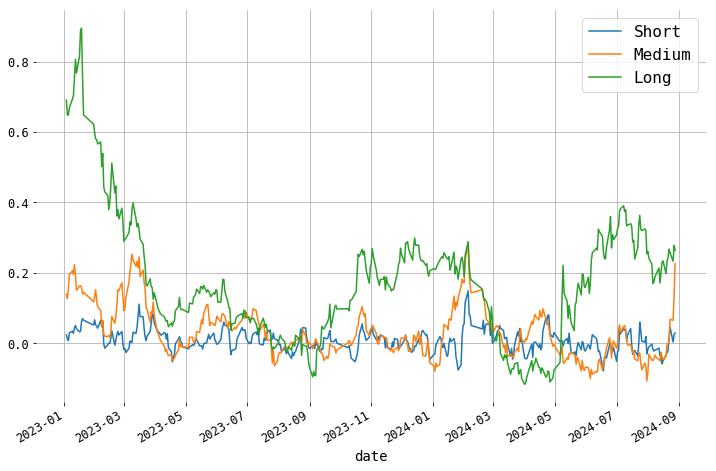

In [12]:
factor_yield_data.plot();

### 步骤2：生成基准的收益率曲线

In [13]:
bench_mark = "159919.XSHE"

In [14]:
bench_mark_pd = get_price(bench_mark, start_date=begin_date , end_date = end_date, frequency='daily',fq='pre', fields=['close'])

In [15]:
bench_mark_pd.columns = ['price']

In [16]:
bench_mark_pd.head()

,price
2023-01-03,3.837
2023-01-04,3.841
2023-01-05,3.916
2023-01-06,3.932
2023-01-09,3.956


In [17]:
bench_mark_pd['Short_Bench'] = bench_mark_pd['price'].shift(-period_short)/bench_mark_pd['price'] -1 
bench_mark_pd['Medium_Bench'] = bench_mark_pd['price'].shift(-period_medium)/bench_mark_pd['price'] -1 
bench_mark_pd['Long_Bench'] = bench_mark_pd['price'].shift(-period_long)/bench_mark_pd['price'] -1 

In [18]:
bench_mark_pd = bench_mark_pd.drop('price', axis =1)
bench_mark_pd = bench_mark_pd.dropna()

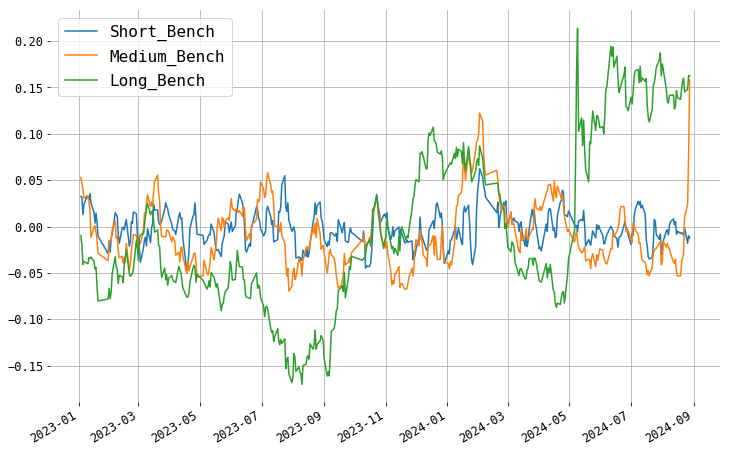

In [19]:
bench_mark_pd.plot();

### 步骤3：生成因子收益率的利差

In [20]:
total_data = pd.concat([bench_mark_pd,factor_yield_data],axis = 1)
total_data.head()

,Short_Bench,Medium_Bench,Long_Bench,Short,Medium,Long
date,,,,,,
2023-01-03,0.032578,0.052906,-0.009643,0.023598,0.139431,0.690608
2023-01-04,0.031242,0.046863,-0.020047,0.013065,0.127051,0.647791
2023-01-05,0.012768,0.040347,-0.040858,0.007767,0.155967,0.648971
2023-01-06,0.023906,0.030519,-0.037894,0.030241,0.194951,0.669348
2023-01-09,0.032609,0.032861,-0.039687,0.034151,0.206140,0.693607


In [21]:
total_data['Spread_Short'] = total_data['Short'] - total_data['Short_Bench']
total_data['Spread_Medium'] = total_data['Medium'] - total_data['Medium_Bench']
total_data['Spread_Long'] = total_data['Long'] - total_data['Long_Bench']

In [59]:
total_data.head()

,Short_Bench,Medium_Bench,Long_Bench,Short,Medium,Long,Spread_Short,Spread_Medium,Spread_Long
date,,,,,,,,,
2023-01-03,0.032578,0.052906,-0.009643,0.023598,0.139431,0.690608,-0.008979,0.086525,0.700251
2023-01-04,0.031242,0.046863,-0.020047,0.013065,0.127051,0.647791,-0.018177,0.080189,0.667837
2023-01-05,0.012768,0.040347,-0.040858,0.007767,0.155967,0.648971,-0.005001,0.115619,0.689829
2023-01-06,0.023906,0.030519,-0.037894,0.030241,0.194951,0.669348,0.006335,0.164432,0.707242
2023-01-09,0.032609,0.032861,-0.039687,0.034151,0.206140,0.693607,0.001542,0.173279,0.733294


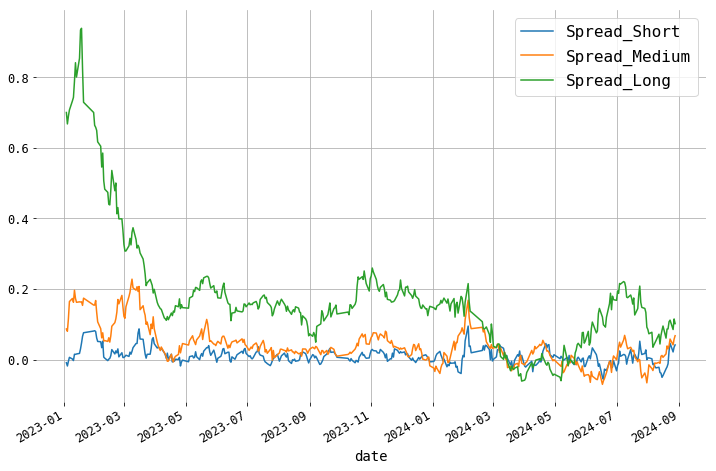

In [22]:
total_data.loc[:,['Spread_Short','Spread_Medium','Spread_Long']].plot();

### 步骤4：调整曲线

In [64]:
Observe_data = pd.DataFrame()

Observe_window = 200


Observe_data['Spread_Short'] = (total_data.loc[:,['Spread_Short']] - total_data.loc[:,['Spread_Short']].median())['Spread_Short']
Observe_data['Spread_Medium'] = (total_data.loc[:,['Spread_Medium']] - total_data.loc[:,['Spread_Medium']].median())['Spread_Medium']
Observe_data['Spread_Long'] = (total_data.loc[:,['Spread_Long']] - total_data.loc[:,['Spread_Long']].median())['Spread_Long']

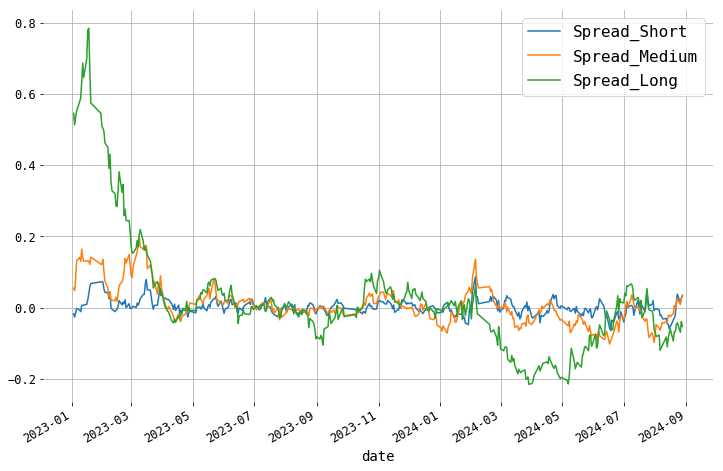

In [65]:
Observe_data.plot()

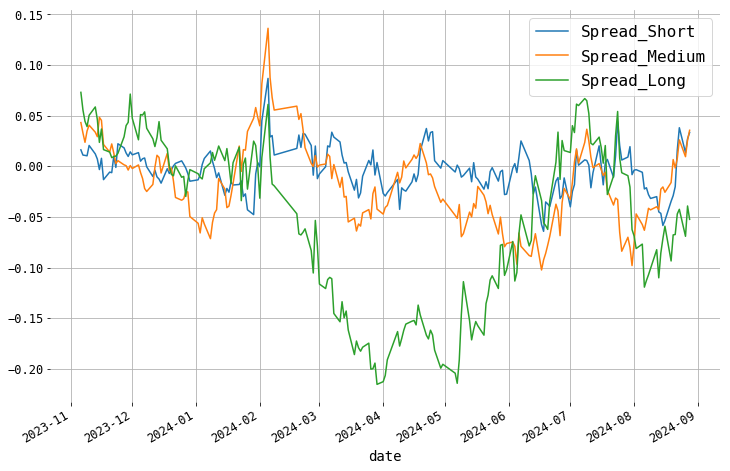

In [70]:
Observe_data.iloc[-Observe_window:].plot()

### 步骤5：进行前面的丢失收益率检查
1. 丢失的起始点如果为负，则哪怕后续收益率为0，自然回归为0，自然上升
2. 丢失的起始点收益为正，则哪怕后续收益率为0，自然回归为0，自然下降


In [99]:
# 找到起始时间丢失的值
Observe_data['Spread_Short'][-period_short:]

date
2024-08-22    0.015972
2024-08-23    0.038053
2024-08-26    0.013457
2024-08-27    0.027082
2024-08-28    0.033335
Name: Spread_Short, dtype: float64

In [98]:
Observe_data['Spread_Short'][-period_short-3:-period_short+1]


date
2024-08-19   -0.034563
2024-08-20   -0.029008
2024-08-21   -0.020155
2024-08-22    0.015972
Name: Spread_Short, dtype: float64

In [92]:
Observe_data['Spread_Medium'][-period_medium-3:-period_medium+1]


date
2024-07-29   -0.070043
2024-07-30   -0.080114
2024-07-31   -0.098020
Name: Spread_Medium, dtype: float64

In [93]:
Observe_data['Spread_Long'][-period_long-3:-period_long+1]


date
2024-03-29   -0.215253
2024-04-01   -0.212601
2024-04-02   -0.206457
Name: Spread_Long, dtype: float64

### 结论：
1. 绿色代表未来100天的利差，黄色代表20天的利差，蓝色代表未来5天的利差
2. 绿色的周期在100天左右，黄色周期约30-40天，蓝色周期约20天
3. 蓝色带动黄色，黄色带动绿色波动
4. 利差为负，说明小市值因子的收益率低于benchmark，未来会在短期、中期的带动下回升
5. 同步检查过去对应周期内的变化，确保不出现大的负面影响
6. 分仓位进行管理